In [ ]:
!pip install category_encoders

In [2]:
import requests
import zipfile
import io
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def descargar_y_descomprimir(url, carpeta_destino="datos"):
    # Crear carpeta si no existe
    os.makedirs(carpeta_destino, exist_ok=True)

    # Descargar archivo
    print("Descargando archivo...")
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Error al descargar archivo: {response.status_code}")

    # Descomprimir desde memoria
    print("Descomprimiendo archivo...")
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(carpeta_destino)

    print(f"Archivo descargado y extraído en '{carpeta_destino}'")

# Ejemplo de uso
# moviews
#url = "https://www.kaggle.com/api/v1/datasets/download/sufyan145/netflix-movies-and-shows-imdb-scores"
# letterbox
url = "https://www.kaggle.com/api/v1/datasets/download/sahilislam007/letterbox-movie-classification-dataset"
descargar_y_descomprimir(url)

Descargando archivo...
Descomprimiendo archivo...
Archivo descargado y extraído en 'datos'


PENSAR:

Nuestro target es calcular el rating promedio de una peliculo o serie a partir de los siguientes datos:
- Director, Genres, Watches, Original_language, Runtime, Studios

Los datos que no podemos usar son:
- Likes, lowest, medium, highest, Total_ratings


Pensar si podemos plantear que Watches es un dato para usar o no. Porque si es para una persona que quiere saber a priori si va a tener rating o no, no nos sirve.

Otro dato que podemos aportar con watches es hacer matriz Gausseana.

Pensando en klustering podemos agregupar personas/peliculas por las clase y ver si resulta por ejemplo personas que le gustan peliculas de culto.

Similar a un sistema de recomendación porque si te gusta una pelicula  te tiene que gustar la del mismo kluster.

In [ ]:
import pandas as pd
import os

# List files in the current directory to find the extracted data file
folder_path = "datos"

if os.path.exists(folder_path):
    files_in_folder = os.listdir(folder_path)
print("Files in the current directory:", files_in_folder)

# Assuming the data is in a CSV file, find the first one
csv_file = None
for file in files_in_folder:
    if file.endswith('.csv'):
        csv_file = file
        break

if csv_file:
    print(f"Loading data from: {folder_path}/{csv_file}")
    # Load the data into a pandas DataFrame
    df = pd.read_csv(f"{folder_path}/{csv_file}")

    # Display the first few rows of the DataFrame
    display(df.head())
else:
    print("No CSV file found in the extracted contents.")

Files in the current directory: ['Letterbox Movie Classification Dataset.csv']
Loading data from: datos/Letterbox Movie Classification Dataset.csv


,Unnamed: 0,Film_title,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Watches,List_appearances,Likes,Fans,Lowest★,Medium★★★,Highest★★★★★,Total_ratings
0,0,The Fan,Eckhart Schmidt,3.57,"['Horror', 'Drama']",92.0,German,The hero-worship that Simone has for a pop sin...,['Barbara Moorse Workshop'],12841,11032,3763,79,129,1660,714,9042
1,1,Mad Max: Fury Road,George Miller,4.18,"['Adventure', 'Science Fiction', 'Action']",121.0,English,An apocalyptic story set in the furthest reach...,"['Warner Bros. Pictures', 'Village Roadshow Pi...",2488721,331681,927538,38000,12530,158356,511140,1682389
2,2,Suspiria,Dario Argento,3.93,['Horror'],99.0,English,An American newcomer to a prestigious German b...,['Seda Spettacoli'],618171,220094,219548,13000,2814,53427,88628,443757
3,3,Lost in Translation,Sofia Coppola,3.79,"['Drama', 'Comedy', 'Romance']",102.0,English,"Two lost souls visiting Tokyo -- the young, ne...","['American Zoetrope', 'Elemental Films']",1596190,254180,493248,38000,15167,155110,193717,1076949
4,4,Akira,Katsuhiro Otomo,4.28,"['Animation', 'Action', 'Science Fiction']",124.0,Japanese,A secret military project endangers Neo-Tokyo ...,"['MBS', 'Sumitomo Corporation', 'TOHO', 'Studi...",873068,175586,341567,21000,1822,40850,196532,600721


Elimos como variable target la columna Average_rating, que muestra el puntaje promedio que la gente le da a cada película o serie. Es un valor **continuo** que resume de forma simple qué tan bien recibida fue una película, y nos va a permitir entrenar un **modelo de regresión** para predecir ese valor usando datos como el género, la duración, el idioma, el estudio y su popularidad.

In [ ]:
# Obtenemos la cardinalidad de cada columna
cardinalidad = df.nunique().sort_values(ascending=False)

print("Cardinalidad de cada variable:")
print(cardinalidad)

# Cantidad de valores nulos por columna
nulos = df.isnull().sum()

print("Cantidad de valores nulos por variable:")
print(nulos)

Cardinalidad de cada variable:
Unnamed: 0           10000
Description           9963
Film_title            9665
Watches               8794
Total_ratings         8338
Studios               8016
List_appearances      7887
Likes                 6741
Medium★★★             6370
Director              4762
Highest★★★★★          4699
Lowest★               3086
Genres                2397
Fans                   963
Average_rating         327
Runtime                301
Original_language       57
dtype: int64
Cantidad de valores nulos por variable:
Unnamed: 0           0
Film_title           0
Director             0
Average_rating       0
Genres               0
Runtime              0
Original_language    0
Description          0
Studios              0
Watches              0
List_appearances     0
Likes                0
Fans                 0
Lowest★              0
Medium★★★            0
Highest★★★★★         0
Total_ratings        0
dtype: int64


## Cardinalidad:
### Variables con cardinalidad muy alta:

Unnamed 0: (10000): probablemente es un índice único, no es útil como variable.

Description (9963) y Film_title (9665): casi todos distintos, como es de esperar.

Watches (8794), Total_ratings (8338), Studios (8016), List_appearances (7887), Likes (6741), Medium★★★ (6370), Director (4762), Highest★★★★★ (4699): también alta variedad, indican datos numéricos o variables con mucha diversidad (por ejemplo, muchos estudios distintos, directores, etc.).

### Variables con cardinalidad media:

Lowest★ (3086), Genres (2397): géneros tienen menos variedad, pero sigue siendo mucho, considerando que es una lista de los géneros de la película.

Fans (963), Average_rating (327), Runtime (301): Runtime es la duración en minutos, con 301 valores únicos parece plausible (rango de duraciones).

### Varuables con cardinalidad baja:

Original_language (57): Se va analizar mas en profundidad para ver si se puede transformar con OneHotEncoding o TargetEncoding.

Vemos que no hay valores nulos en ninguna variable. En principio, no tenemos que hacer niguna imputación de nulos.

In [ ]:
a = df[df['Film_title'].str.contains('Hercules', case=False, na=False)]
a.head(3)

,Unnamed: 0,Film_title,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Watches,List_appearances,Likes,Fans,Lowest★,Medium★★★,Highest★★★★★,Total_ratings
173,173,Hercules,"Ron Clements, John Musker",3.82,"['Animation', 'Adventure', 'Romance', 'Comedy'...",93.0,English,"Bestowed with superhuman strength, a young mor...","['Walt Disney Pictures', 'Walt Disney Feature ...",1318587,115062,291974,6200,3188,107615,115996,627632
442,442,Hercules,Luigi Cozzi,2.65,"['Fantasy', 'Action', 'Adventure']",98.0,English,"Hercules, a semi-divine being, squares off aga...","['Golan-Globus Productions', 'Cannon Italia Sr...",5221,3625,884,7,322,721,122,3314
775,775,Hercules,Brett Ratner,2.28,"['Action', 'Adventure']",98.0,English,"When a new enemy threatens the innocent, Hercu...","['Paramount Pictures', 'Radical Studios', 'Fly...",99639,9824,6391,11,5521,12639,659,58564


Identificamos que en el dataset existen películas que comparten el mismo título pero tienen directores diferentes, lo cual asumimos indica que son producciones distintas. Por eso, consideraremos cada combinación de título y director como una entrada única para evitar confusiones o duplicados indebidos en el análisis.

In [ ]:
# Features (X) y Target (y)

random_state = 42
# Definimos las features eliminando columnas que no aportan o son irrelevantes para este modelo
X = df.drop(columns=['Unnamed: 0', 'Film_title', 'Average_rating', 'List_appearances',
                     'Likes', 'Fans', 'Lowest★', 'Medium★★★',	'Highest★★★★★',	'Total_ratings', 'Description'])

# Target
y = df['Average_rating']

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

print("Tamaño train:", X_train.shape)
print("Tamaño test:", X_test.shape)

Tamaño train: (8000, 6)
Tamaño test: (2000, 6)


In [ ]:
df["Average_rating"].describe()

,Average_rating
count,10000.000000
mean,3.268535
std,0.525744
min,1.080000
25%,2.950000
50%,3.268535
75%,3.620000
max,4.710000


La variable objetivo `Average_rating` es un valor continuo que varía entre 1 y 5. Dado que buscamos predecir un valor numérico continuo, utilizaremos un modelo de **regresión**.

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Director           8000 non-null   object 
 1   Genres             8000 non-null   object 
 2   Runtime            8000 non-null   float64
 3   Original_language  8000 non-null   object 
 4   Studios            8000 non-null   object 
 5   Watches            8000 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 437.5+ KB


## Analisis de la variable Director:

No vamos a usar OneHot porque genera muchísimas columnas.

Usaremos Target Encoding

Número total de directores únicos: 4762
Top 20 directores con más películas:
Director
Chuck Jones           50
Cirio H. Santiago     42
Antonio Margheriti    39
Steven Spielberg      31
Robert Stevenson      31
Roy Rowland           28
Roger Corman          28
William Witney        28
Sergio Martino        27
Ridley Scott          26
Sergio Corbucci       26
J. Lee Thompson       26
Ken Russell           24
Woody Allen           23
Richard Donner        22
Joel Schumacher       22
Steven Soderbergh     22
John Sturges          21
Howard Hawks          21
Wes Craven            21
Name: count, dtype: int64


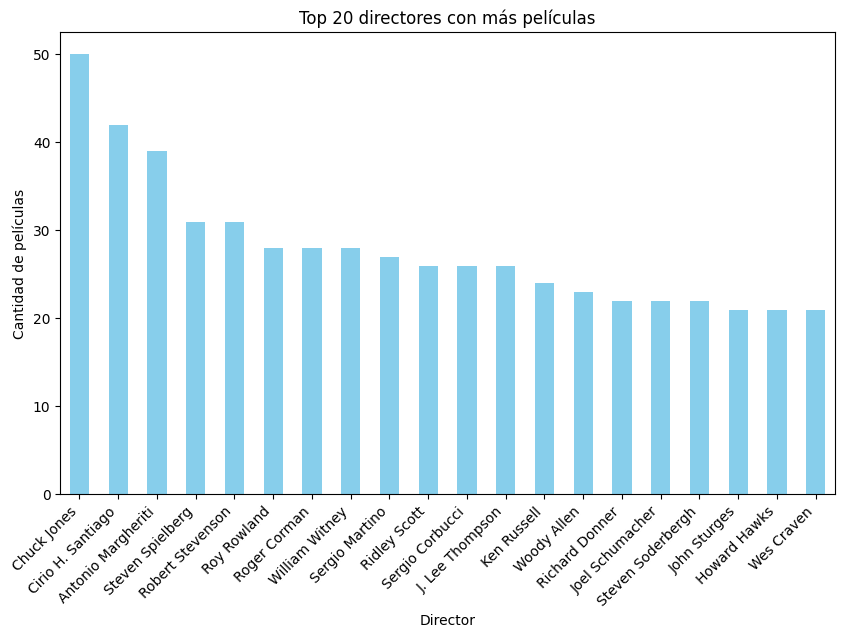

In [ ]:

# Mostrar cuántos directores únicos hay
num_directores = df['Director'].nunique()
print(f"Número total de directores únicos: {num_directores}")

# Mostrar los 20 directores con más películas en el dataset
top_directores = df['Director'].value_counts().head(20)
print("Top 20 directores con más películas:")
print(top_directores)

# Gráfico de barras de los 20 directores con más películas
plt.figure(figsize=(10,6))
top_directores.plot(kind='bar', color='skyblue')
plt.title('Top 20 directores con más películas')
plt.xlabel('Director')
plt.ylabel('Cantidad de películas')
plt.xticks(rotation=45, ha='right')
plt.show()

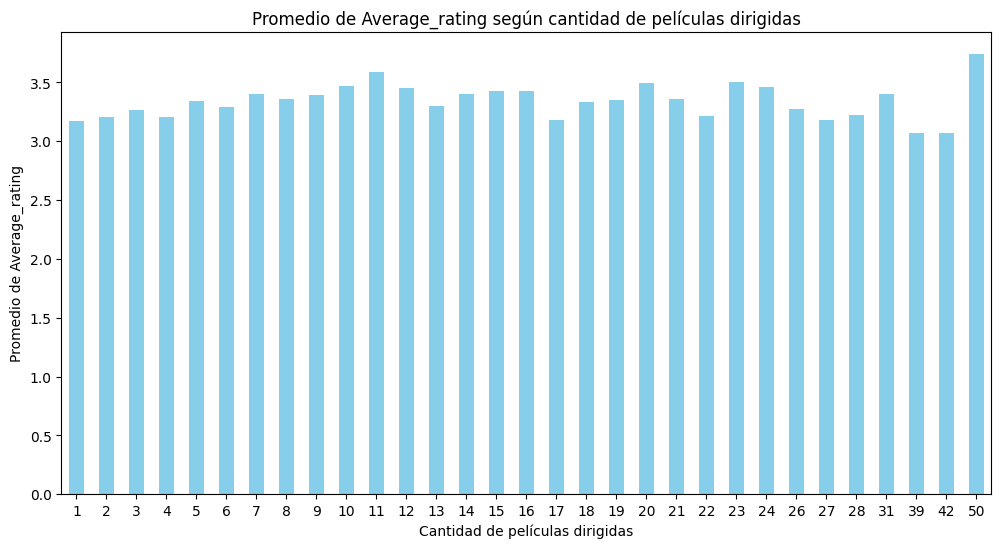

In [ ]:
# Contar cuántas películas tiene cada director
peliculas_por_director = df['Director'].value_counts()

# Crear un DataFrame con director y cantidad de películas
df_directores = pd.DataFrame({
    'Director': peliculas_por_director.index,
    'Cantidad_peliculas': peliculas_por_director.values
})

# Unir con el dataset original para obtener el Average_rating por director
df_merge = pd.merge(df, df_directores, on='Director')

# Calcular promedio de Average_rating agrupado por cantidad de películas dirigidas
rating_por_cantidad = df_merge.groupby('Cantidad_peliculas')['Average_rating'].mean()

# Gráfico
plt.figure(figsize=(12,6))
rating_por_cantidad.plot(kind='bar', color='skyblue')
plt.title('Promedio de Average_rating según cantidad de películas dirigidas')
plt.xlabel('Cantidad de películas dirigidas')
plt.ylabel('Promedio de Average_rating')
plt.xticks(rotation=0)
plt.show()

Vemos que por más que los directores hagan una sóla película, el promedio del rating no es malo, por encima de 3 puntos.
Como es de esperar el director Chuck Jones que hizo 50 películas tiene un promedio por encima de 3.5. Pero Cirio H. Santiago y Antonio Margheriti tienen mucho menos, promedian 3 puntos.

# Análisis de la variable Genres

In [ ]:
import ast

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val  # Si no puede convertir, devuelve el valor tal cual

df['Genres_original'] = df['Genres']

df['Genres'] = df['Genres'].apply(safe_literal_eval)


In [ ]:
### pensar si esto hay que hacer de df o de X_train

print(df['Genres'].apply(type).value_counts())
df['Genres'] = df['Genres'].astype(str).str.replace("'", '"')  # Cambiar comillas simples por dobles
df['Genres'].head()
import json
def parse_json(val):
    try:
        return json.loads(val)
    except json.JSONDecodeError:
        return []

df['Genres'] = df['Genres'].apply(parse_json)

df['Genres'].head()

Genres
<class 'list'>    9976
<class 'str'>       24
Name: count, dtype: int64


,Genres
0,"[Horror, Drama]"
1,"[Adventure, Science Fiction, Action]"
2,[Horror]
3,"[Drama, Comedy, Romance]"
4,"[Animation, Action, Science Fiction]"


<Figure size 1200x600 with 0 Axes>

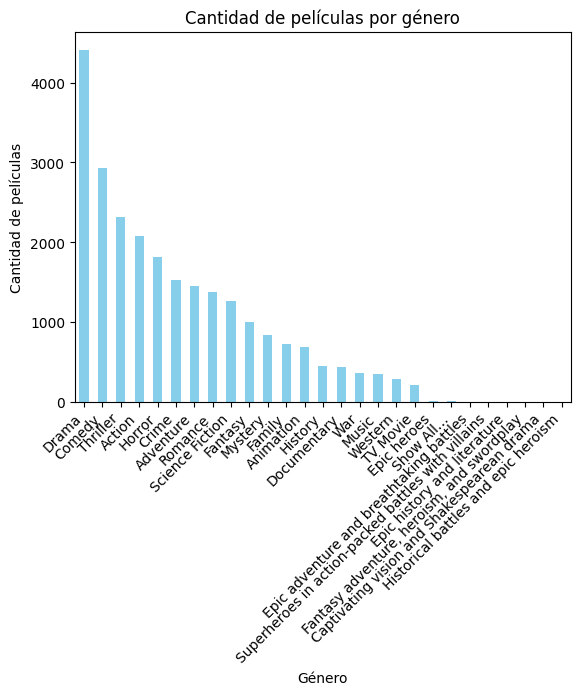

27


In [ ]:

# Aplanar la lista de géneros
all_genres = [genre for sublist in df['Genres'] for genre in sublist]

# Contar frecuencia
genre_counts = Counter(all_genres)

# Convertir a DataFrame para graficar
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])
genre_counts_df = genre_counts_df.sort_values('Count', ascending=False)

# Graficar
plt.figure(figsize=(12,6))
genre_counts_df.plot(kind='bar', legend=False, color='skyblue')
plt.title('Cantidad de películas por género')
plt.xlabel('Género')
plt.ylabel('Cantidad de películas')
plt.xticks(rotation=45, ha='right')
plt.show()

print(len(genre_counts))

Confirmamos que no hay valores nulos y hay 27 géneros distintos.

Estadísticas descriptivas de Runtime:
count    10000.000000
mean       103.169352
std         38.070735
min          2.000000
25%         89.000000
50%         99.000000
75%        113.000000
max        907.000000
Name: Runtime, dtype: float64


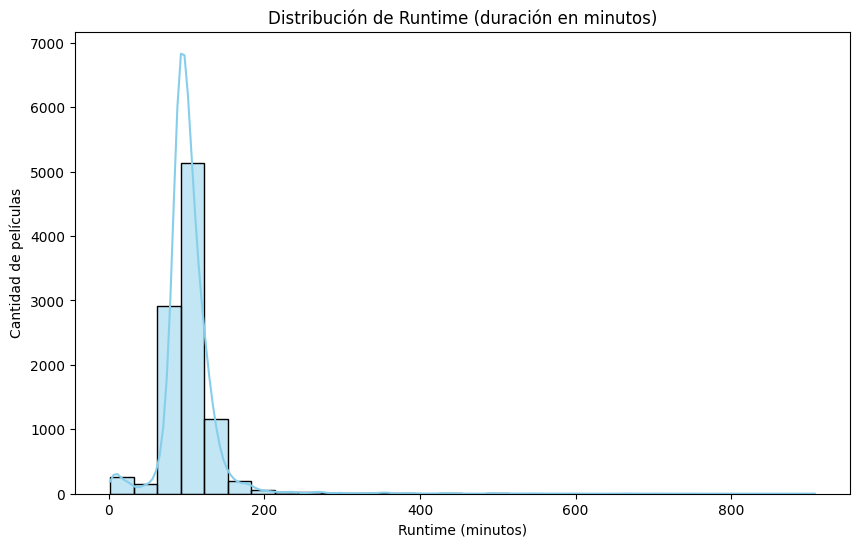

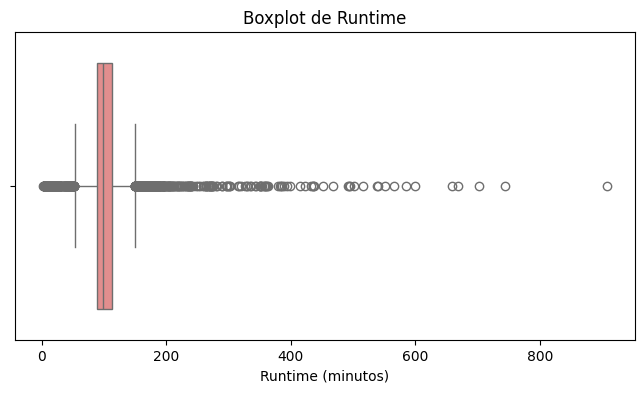

In [ ]:
# Estadísticas descriptivas
print("Estadísticas descriptivas de Runtime:")
print(df['Runtime'].describe())

# Histograma de la distribución de Runtime
plt.figure(figsize=(10,6))
sns.histplot(df['Runtime'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de Runtime (duración en minutos)')
plt.xlabel('Runtime (minutos)')
plt.ylabel('Cantidad de películas')
plt.show()

# Boxplot para detectar outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Runtime'], color='lightcoral')
plt.title('Boxplot de Runtime')
plt.xlabel('Runtime (minutos)')
plt.show()

Notamos muchos outliers
Por la duración creemos que no todas son peliculas.
### ver que hacer con esto y si afecta algo al resultado ###

In [ ]:
X_train.head()

,Director,Genres,Runtime,Original_language,Studios,Watches
9254,Mai Masri,"['History', 'Documentary']",50.0,Arabic,"['Arab Film Distribution', 'Nour Productions']",1761
1561,Steven Spielberg,"['War', 'Adventure', 'History']",146.0,English,"['DreamWorks Pictures', 'Reliance Entertainmen...",218184
1670,"Mel Welles, Aureliano Luppi","['Horror', 'Science Fiction']",99.0,Italian,"['Condor International Productions', 'New Worl...",3861
6087,Arch Hall Sr.,"['Science Fiction', 'Romance', 'Horror']",92.0,English,['Fairway International Pictures'],4725
6669,Humberto Hinojosa,"['Comedy', 'Drama', 'Science Fiction']",94.0,Spanish,"['Filmadora Nacional', 'Tigre Pictures', 'Film...",2919


In [ ]:
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.ensemble import RandomForestRegressor

def join_genres(X):
    X = X.copy()
    X["Genres"] = X["Genres"].apply(lambda g: "|".join(g) if isinstance(g, list) else g)
    X["Studios"] = X["Studios"].apply(lambda g: "|".join(g) if isinstance(g, list) else g)
    return X

target_columns = ["Genres", "Studios", "Director", "Original_language"]
numeric_columns = ["Watches", "Runtime"]

# Pipelines
pipeline_target = Pipeline([
    ("join_genres", FunctionTransformer(join_genres)),
    ("target_encode", TargetEncoder(cols=target_columns))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("targets", pipeline_target, target_columns),
        ("numerics", RobustScaler(), numeric_columns)
    ]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# -----------------------------
# 5. Fit en train y predecir en test
# -----------------------------
# Asumiendo que ya hiciste split:
# X_train, X_test, y_train, y_test

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = pipeline.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 0.3828076764409301
RMSE: 0.24966022320388634
R2: 0.08901227156808855


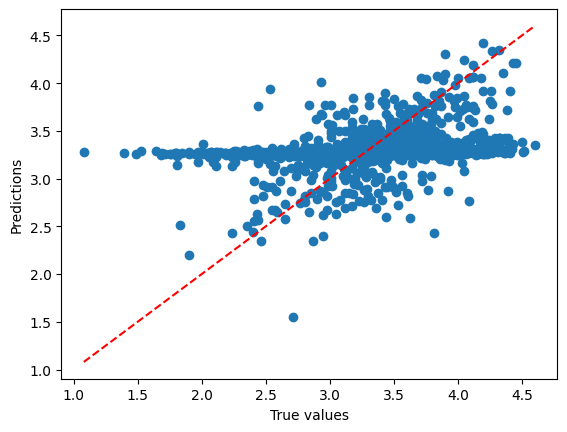

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("True values")
plt.ylabel("Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

JONI: la predicción es muy muy mala. Ver de crear variable a partir de runtime

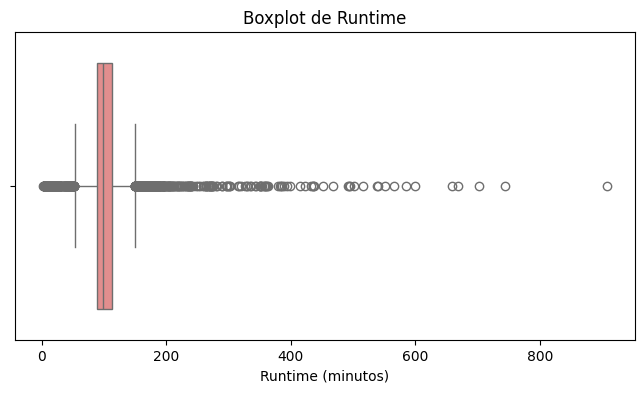

In [ ]:
# Boxplot para detectar outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=df_transformed['Runtime'], color='lightcoral')
plt.title('Boxplot de Runtime')
plt.xlabel('Runtime (minutos)')
plt.show()


In [ ]:
peliculas_largas = df[df['Runtime'] > 200]['Film_title']
print("Películas con duración mayor a 200 minutos:")
print(peliculas_largas.to_list())

Películas con duración mayor a 200 minutos:
['Lawrence of Arabia', 'Gone with the Wind', 'The Godfather Part II', 'O.J.: Made in America', 'War and Peace', '1900', 'Ben-Hur', 'The Ten Commandments', 'Jason and the Argonauts', 'Malcolm X', 'Giant', '11.22.63', 'Lonesome Dove', 'Ultraviolet', 'Once Upon a Time in America', 'The Stand', 'Gettysburg', 'The Night Manager', 'Shoah', 'Seven Samurai', 'The Kingdom', 'Bangkok Hilton', 'Woodstock', 'War and Peace', 'Spy Smasher', "Zorro's Fighting Legion", 'Drums of Fu Manchu', 'Mysterious Doctor Satan', 'Zorro Rides Again', 'The Fighting Devil Dogs', 'Daredevils of the Red Circle', 'Jungle Girl', 'Dick Tracy Returns', 'Dick Tracy vs. Crime Inc.', "Dick Tracy's G-Men", 'SOS Coast Guard', 'The Lone Ranger', 'Jesus of Nazareth', "Boccaccio '70", 'Out 1', 'La Belle Noiseuse', 'Homeland: Iraq Year Zero', 'Gods and Generals', 'Never Sleep Again: The Elm Street Legacy', 'Planet Earth II', 'Blue Planet II', 'Brideshead Revisited', 'Cleopatra', 'Apple T

Conteo de idiomas originales: 57
Original_language
English                             8074
Italian                              396
Japanese                             308
French                               291
Korean                               145
Spanish                              115
German                                96
No spoken language                    94
Chinese                               66
Danish                                60
Cantonese                             58
Russian                               43
Swedish                               32
Polish                                20
Dutch                                 20
Portuguese                            19
Romanian                              18
Persian (Farsi)                       15
Norwegian                             14
Arabic                                14
Czech                                 12
Greek (modern)                         9
Hindi                                  9
Hungar

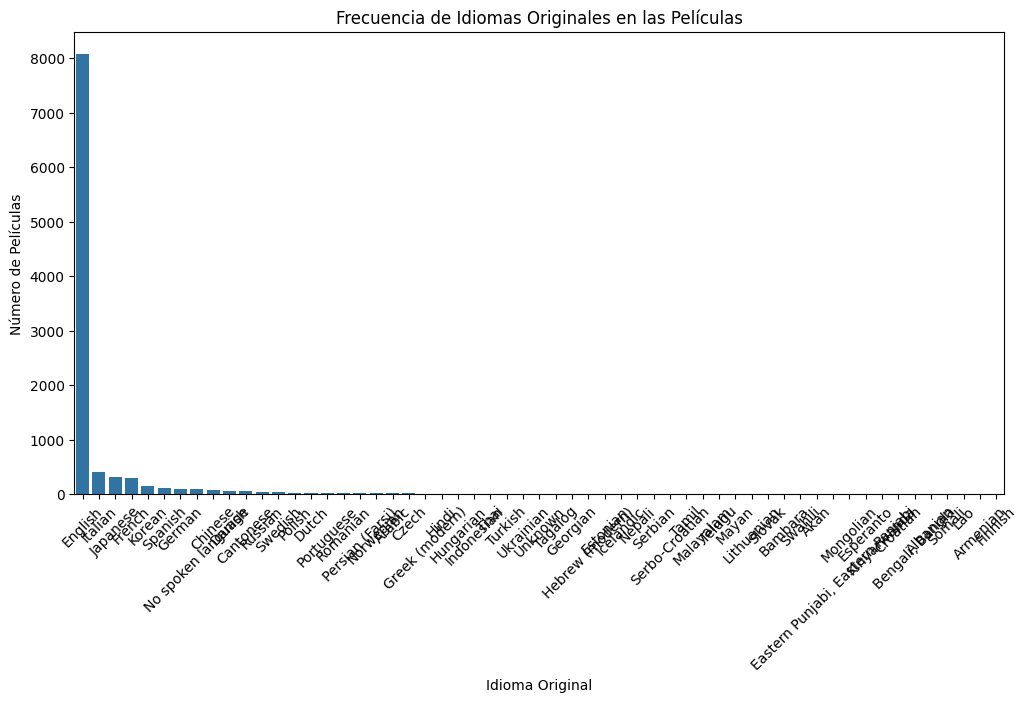

In [ ]:
print(f"Conteo de idiomas originales: {len(df['Original_language'].value_counts())}")
print(df['Original_language'].value_counts())

# Porcentaje relativo de cada idioma
print("\nPorcentaje de idiomas originales:")
print(df['Original_language'].value_counts(normalize=True) * 100)

# Gráfico de barras con la frecuencia de cada idioma
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Original_language', order=df['Original_language'].value_counts().index)
plt.title('Frecuencia de Idiomas Originales en las Películas')
plt.xlabel('Idioma Original')
plt.ylabel('Número de Películas')
plt.xticks(rotation=45)
plt.show()

Vemos que no hay nulos y en total hay 57 idiomas diferentes, lo cual es mucho.
Luego vamos a agrupar los idiomas antes de hacer un one hot encoding o target encoding

Las clases Movie y Show tienen medias distintas y no tienen nulos. Por ahora es relevante y no hace falta imputar. Sólo convertirla a númerica.

In [ ]:
print("Valores vacíos en 'Description':", (df['Description'].str.strip() == '').sum())

Valores vacíos en 'Description': 0


Estadísticas de longitud de descripción:
count    10000.000000
mean       264.950200
std        141.208441
min         25.000000
25%        154.000000
50%        233.000000
75%        351.000000
max        998.000000
Name: desc_length, dtype: float64


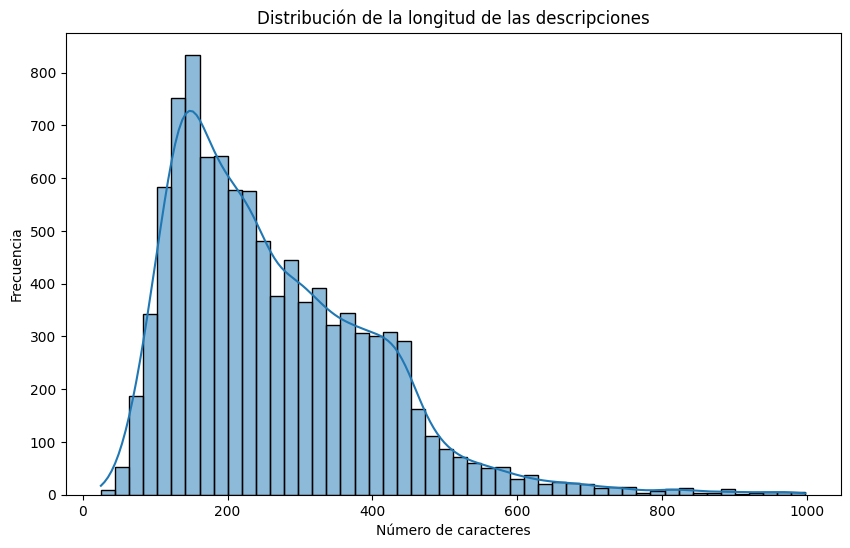

In [ ]:
df['desc_length'] = df['Description'].fillna('').apply(len)
# Estadísticas básicas
print("Estadísticas de longitud de descripción:")
print(df['desc_length'].describe())

# 3. Histograma de longitudes
plt.figure(figsize=(10,6))
sns.histplot(df['desc_length'], bins=50, kde=True)
plt.title('Distribución de la longitud de las descripciones')
plt.xlabel('Número de caracteres')
plt.ylabel('Frecuencia')
plt.show()

# 4. Palabras más frecuentes (simple tokenización por espacios)
all_words = ' '.join(df['Description'].dropna()).lower().split()
word_counts = Counter(all_words)

Palabras más frecuentes (excluyendo stopwords comunes):
he: 3413
their: 2800
who: 2451
when: 2415
but: 1934
they: 1914
has: 1573
into: 1551
are: 1546
she: 1532
after: 1500
young: 1243
new: 1220
one: 1120
him: 1096
up: 1086
out: 1009
two: 980
be: 936
life: 922


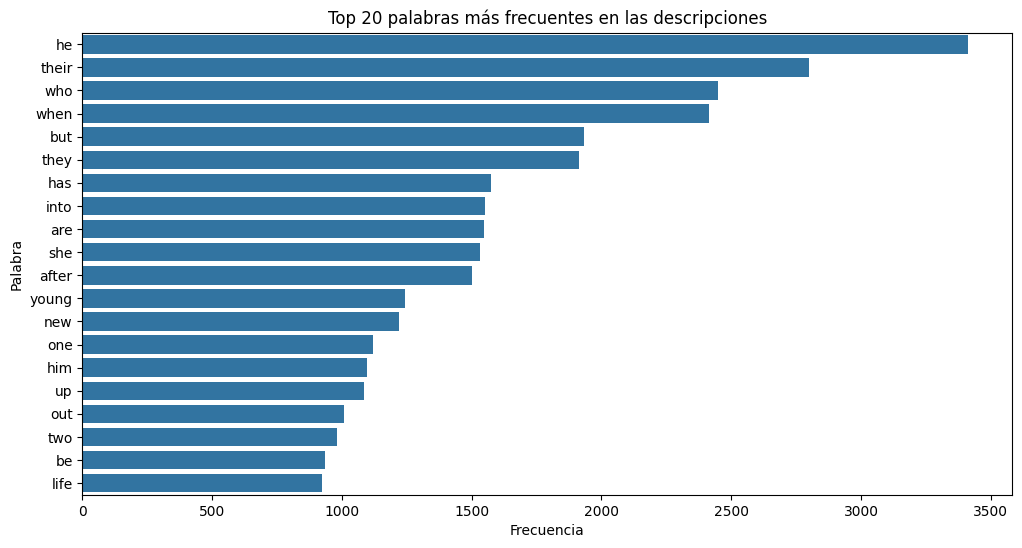

In [ ]:
# Mostrar las 20 palabras más comunes excluyendo stopwords básicas
stopwords = set(['the', 'a', 'and', 'of', 'to', 'in', 'is', 'with', 'on', 'for', 'as', 'an', 'at', 'by', 'from', 'it', 'this', 'that', 'his', 'her'])
filtered_words = {word: count for word, count in word_counts.items() if word not in stopwords}

most_common = Counter(filtered_words).most_common(20)
print("Palabras más frecuentes (excluyendo stopwords comunes):")
for word, count in most_common:
    print(f"{word}: {count}")

# Opcional: gráfico de barras para las palabras más frecuentes
words, counts = zip(*most_common)
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 palabras más frecuentes en las descripciones')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

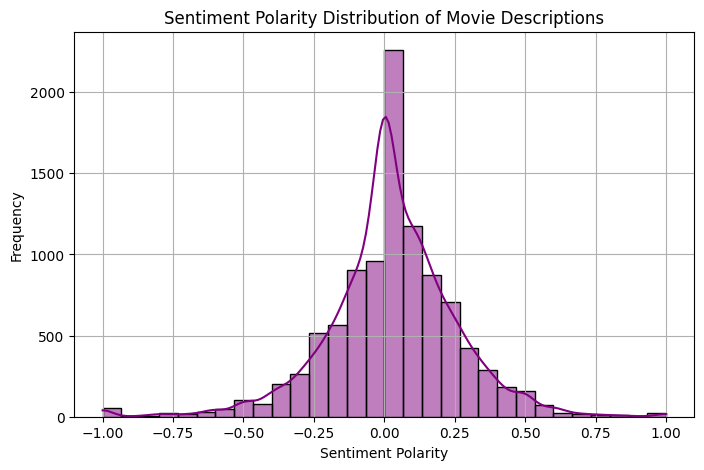

In [ ]:
from textblob import TextBlob

df['Sentiment'] = df['Description'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(8,5))
sns.histplot(df['Sentiment'], bins=30, kde=True, color='purple')
plt.title("Sentiment Polarity Distribution of Movie Descriptions")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### no sabemos que hacer con esto, tal vez en al pasarla a numerica podamos hacer algo mejor

## Variable Studios

/tmp/ipython-input-3001274545.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_studios_watch.values, y=top_studios_watch.index, palette='YlGnBu')


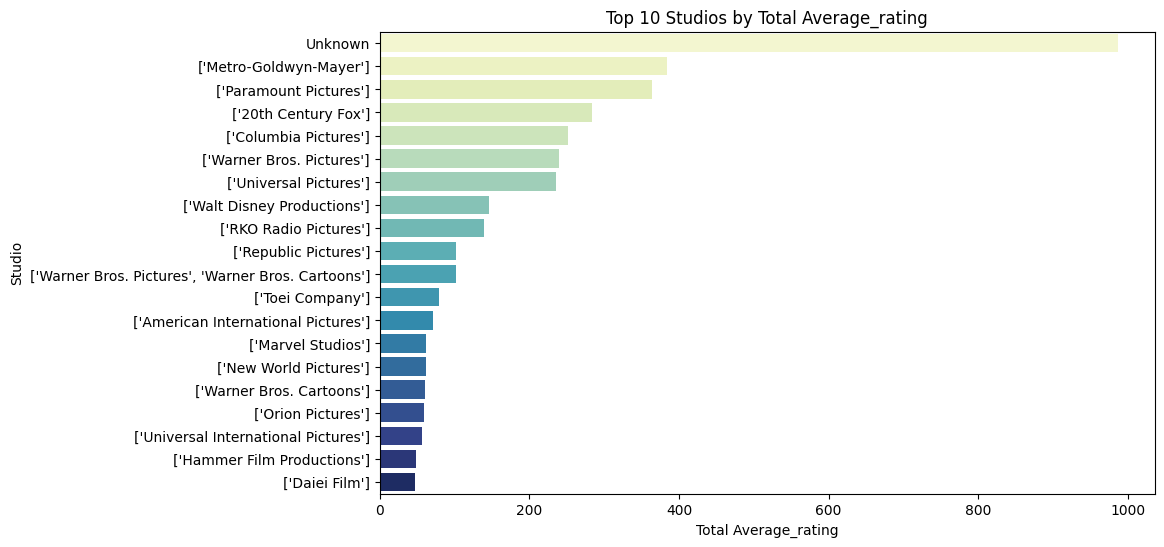

In [ ]:
studio_list = df['Studios'].explode()
df_exploded = df.explode('Studios')  # so we can use it for aggregation

studio_watch = df_exploded.groupby('Studios')['Average_rating'].sum()
top_studios_watch = studio_watch.sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_studios_watch.values, y=top_studios_watch.index, palette='YlGnBu')
plt.title("Top 10 Studios by Total Average_rating")
plt.xlabel("Total Average_rating")
plt.ylabel("Studio")
plt.show()

Top 20 estudios más frecuentes:
Warner Bros. Pictures: 502
Paramount Pictures: 423
Columbia Pictures: 411
Universal Pictures: 410
20th Century Fox: 367
Metro-Goldwyn-Mayer: 317
Unknown: 307
United Artists: 165
New Line Cinema: 146
Walt Disney Pictures: 116
Lionsgate: 93
Film4 Productions: 91
Touchstone Pictures: 83
Relativity Media: 82
American International Pictures: 82
Working Title Films: 78
DreamWorks Pictures: 77
TriStar Pictures: 73
Orion Pictures: 71
Village Roadshow Pictures: 70


/tmp/ipython-input-1900431273.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=studios_df, x='Count', y='Studio', palette='viridis')


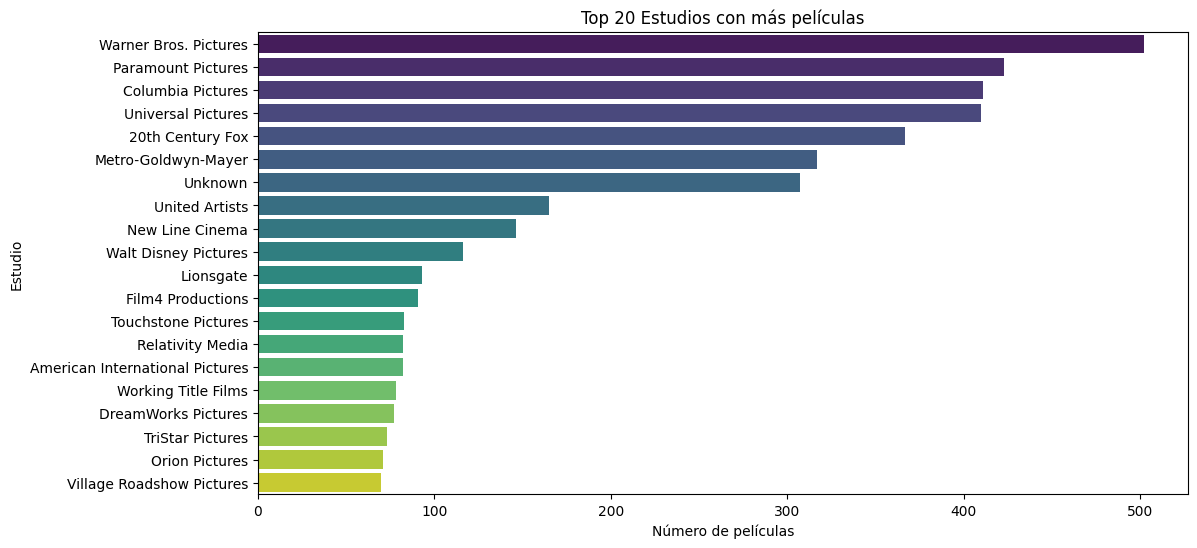

Cantidad de estudios diferentes: 10155
{'Musifilm Productions', 'Pro7', 'Spelling Films', 'The Olen Company', 'Lance Entertainment', 'Film Art Media', 'Room 101', 'Zinc Entertainment Inc.', 'Robert Rehme Productions', 'Longridge Productions', 'Signature Pictures', 'Diamond Docs', 'J.C.STAFF', 'Inferno Entertainment', 'AtEntertainment K.K.', 'Unfaithful Filmproduktion', 'BNNVARA', 'IMAGICA', 'Infinitum Nihil', 'jellyfish Bloom', 'Sound Mind Studio', 'The Caddo Company', 'Cosmic Picture', 'Rotana Film Production', 'Near Dark Joint Venture', 'Central Motion Picture Corporation', 'Medallion Films', 'Contracosta Produções', 'J D Productions', 'Perlberg-Seaton Productions', 'Forum Distribution', 'Fox Family Films', 'Sunstar Entertainment', 'Guerilla High Productions', 'Producciones Benito Perojo', 'Ascension Productions', 'Toho Eizo Bijutsu', 'Filmways Pictures', 'Media Talent Group', 'Virgin Produced', 'Rossen Films', 'ShadowMachine', 'Millenium Films', 'OrëZäne Films', 'Mosaic', 'Bullwinkl

In [ ]:
import ast
from collections import Counter
import pandas as pd

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val  # Devuelve el valor original si no es evaluable

# Suponiendo df ya cargado
df['Studios_original'] = df['Studios']
df['Studios'] = df['Studios'].apply(safe_literal_eval)

# Ahora solo aplanar cuando sea lista, sino ignorar o convertir en lista de un solo elemento
all_studios = []
for item in df['Studios']:
    if isinstance(item, list):
        all_studios.extend(item)
    elif isinstance(item, str):
        # Por si algunos son strings simples, añadir como único estudio
        all_studios.append(item)
    else:
        # Si es otro tipo, puedes ignorar o manejar según convenga
        pass

# Contar frecuencia
studio_counts = Counter(all_studios)


# Mostrar top 20
most_common_studios = studio_counts.most_common(20)
print("Top 20 estudios más frecuentes:")
for studio, count in most_common_studios:
    print(f"{studio}: {count}")


# Convertir a DataFrame para graficar
studios_df = pd.DataFrame(most_common_studios, columns=['Studio', 'Count'])

# Gráfico de barras
plt.figure(figsize=(12,6))
sns.barplot(data=studios_df, x='Count', y='Studio', palette='viridis')
plt.title('Top 20 Estudios con más películas')
plt.xlabel('Número de películas')
plt.ylabel('Estudio')
plt.show()

num_studios_unicos = len(set(all_studios))
print(f"Cantidad de estudios diferentes: {num_studios_unicos}")
print(set(all_studios))

Vemos que hay más de 300 peliculas que tiene el studio Unknown

# Analisis de la variable Watches

Valores nulos en Watches: 0

Resumen estadístico de Watches:
count    1.000000e+04
mean     1.703148e+05
std      4.585329e+05
min      2.000000e+00
25%      2.979750e+03
50%      1.842500e+04
75%      1.083580e+05
max      5.195503e+06
Name: Watches, dtype: float64


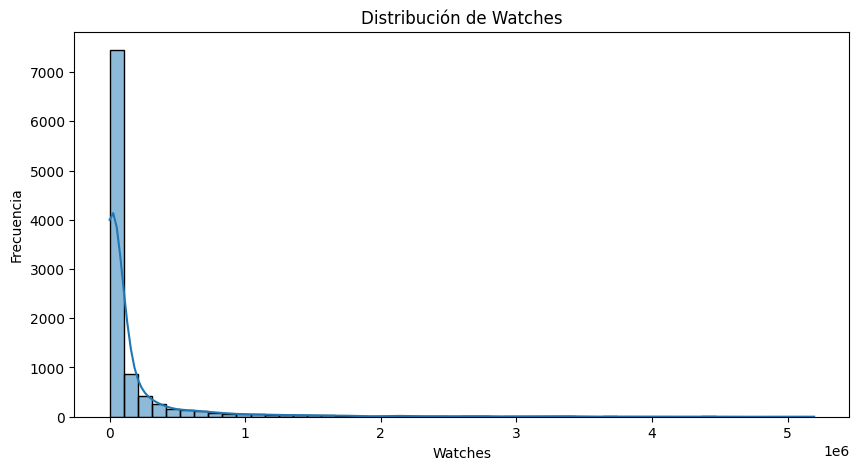

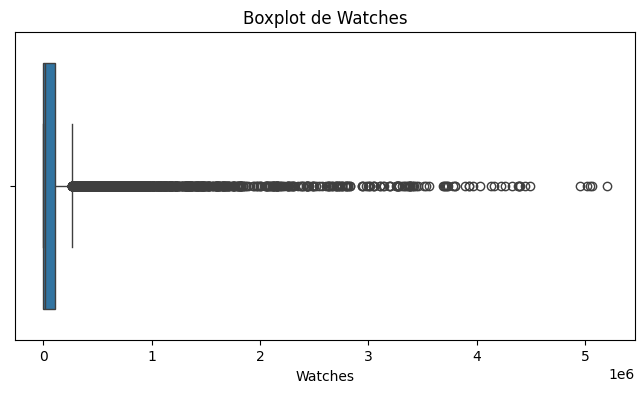


Cantidad de outliers: 1427
Ejemplos de outliers:
                    Film_title  Watches
1           Mad Max: Fury Road  2488721
2                     Suspiria   618171
3          Lost in Translation  1596190
4                        Akira   873068
6  Big Trouble in Little China   283873


In [ ]:
print("Valores nulos en Watches:", df['Watches'].isnull().sum())
print("\nResumen estadístico de Watches:")
print(df['Watches'].describe())

# --- 2. Histograma ---
plt.figure(figsize=(10,5))
sns.histplot(df['Watches'], bins=50, kde=True)
plt.title('Distribución de Watches')
plt.xlabel('Watches')
plt.ylabel('Frecuencia')
plt.show()

# --- 3. Boxplot para detectar outliers ---
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Watches'])
plt.title('Boxplot de Watches')
plt.show()

# --- 4. Detectar valores atípicos ---
Q1 = df['Watches'].quantile(0.25)
Q3 = df['Watches'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Watches'] < (Q1 - 1.5 * IQR)) | (df['Watches'] > (Q3 + 1.5 * IQR))]

print(f"\nCantidad de outliers: {len(outliers)}")
print("Ejemplos de outliers:")
print(outliers[['Film_title', 'Watches']].head())

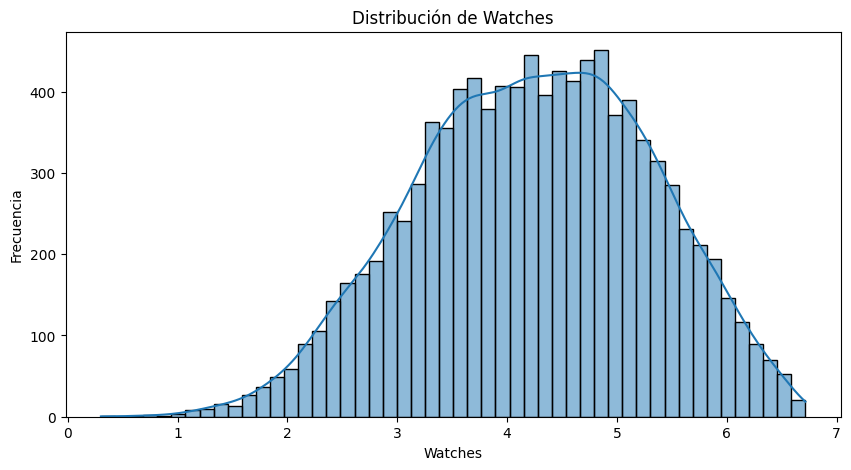

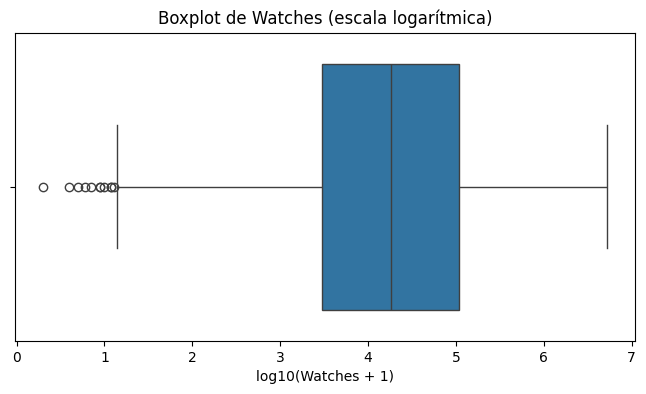

In [ ]:
import numpy as np

plt.figure(figsize=(10,5))
sns.histplot(x=np.log10(df['Watches']), bins=50, kde=True)
plt.title('Distribución de Watches')
plt.xlabel('Watches')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=np.log10(df['Watches']))  # log1p para evitar problemas con ceros
plt.title('Boxplot de Watches (escala logarítmica)')
plt.xlabel('log10(Watches + 1)')
plt.show()

Se cambió la escala a Logarítmica para que los datos esten dentro de los percentiles

# Analisis List_appearances


===== List_appearances =====
count     10000.000000
mean      26868.798600
std       56751.328696
min          33.000000
25%        1674.000000
50%        6503.000000
75%       23908.250000
max      803670.000000
Name: List_appearances, dtype: float64
Valores nulos: 0


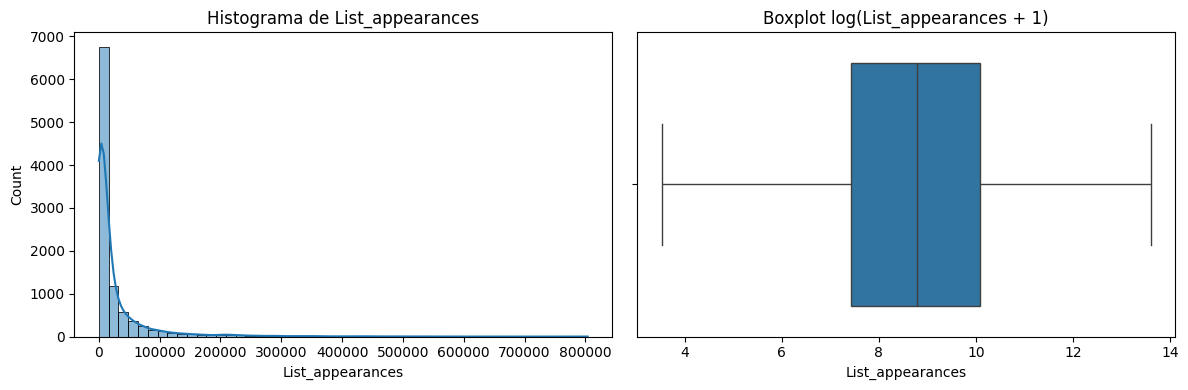

In [ ]:
col = "List_appearances"

print(f"\n===== {col} =====")
print(df[col].describe())
print(f"Valores nulos: {df[col].isnull().sum()}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma normal
sns.histplot(df[col], bins=50, ax=axes[0], kde=True)
axes[0].set_title(f'Histograma de {col}')

# Boxplot en escala logarítmica
sns.boxplot(x=np.log1p(df[col]), ax=axes[1])
axes[1].set_title(f'Boxplot log({col} + 1)')

plt.tight_layout()
plt.show()

Tiene una distribución asimétrica positiva (Tweedie), sin outliers

# Analisis de Likes


===== Likes =====
count    1.000000e+04
mean     4.373479e+04
std      1.515314e+05
min      0.000000e+00
25%      4.570000e+02
50%      3.394000e+03
75%      2.011225e+04
max      2.730813e+06
Name: Likes, dtype: float64
Valores nulos: 0


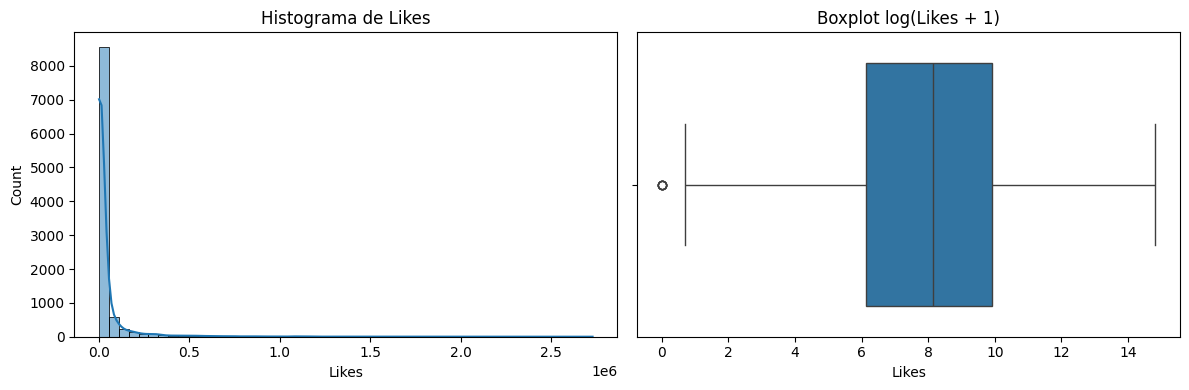

In [ ]:
col = "Likes"

print(f"\n===== {col} =====")
print(df[col].describe())
print(f"Valores nulos: {df[col].isnull().sum()}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma normal
sns.histplot(df[col], bins=50, ax=axes[0], kde=True)
axes[0].set_title(f'Histograma de {col}')

# Boxplot en escala logarítmica
sns.boxplot(x=np.log1p(df[col]), ax=axes[1])
axes[1].set_title(f'Boxplot log({col} + 1)')

plt.tight_layout()
plt.show()

Creo que los outliers que están en cero tenemos que reemplazarlo por la mediana

# Analisis de la variable Fans


===== Fans =====
count     10000.000000
mean       1652.549700
std        9368.258118
min           0.000000
25%           2.000000
50%          24.000000
75%         283.000000
max      326000.000000
Name: Fans, dtype: float64
Valores nulos: 0


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


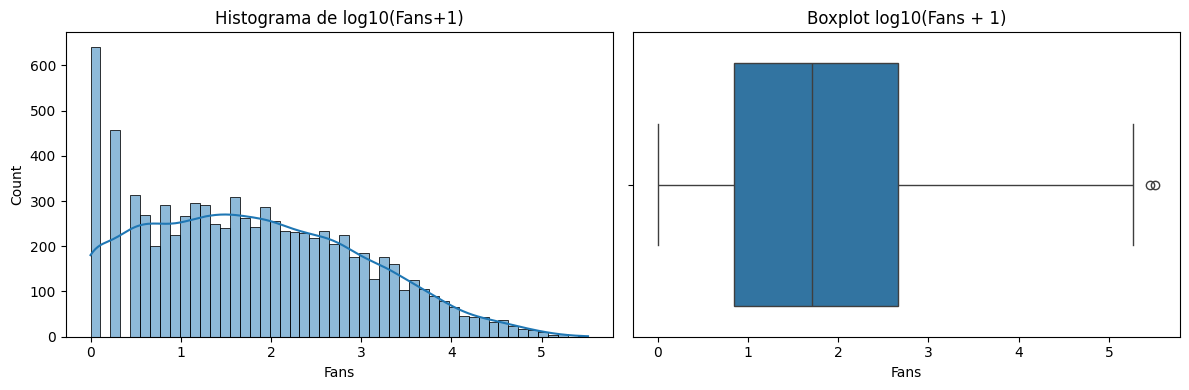

In [ ]:
col = "Fans"

print(f"\n===== {col} =====")
print(df[col].describe())
print(f"Valores nulos: {df[col].isnull().sum()}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma normal
sns.histplot(x=np.log10(df[col]), bins=50, ax=axes[0], kde=True)
axes[0].set_title(f'Histograma de log10({col}+1)')

# Boxplot en escala logarítmica
sns.boxplot(x=np.log10(df[col]), ax=axes[1])
axes[1].set_title(f'Boxplot log10({col} + 1)')

plt.tight_layout()
plt.show()

## tenemos que consultar que hacer con Studios porque se repiten como por ejemplo Warnes Bross entertainment y Warnes Bross sarasa

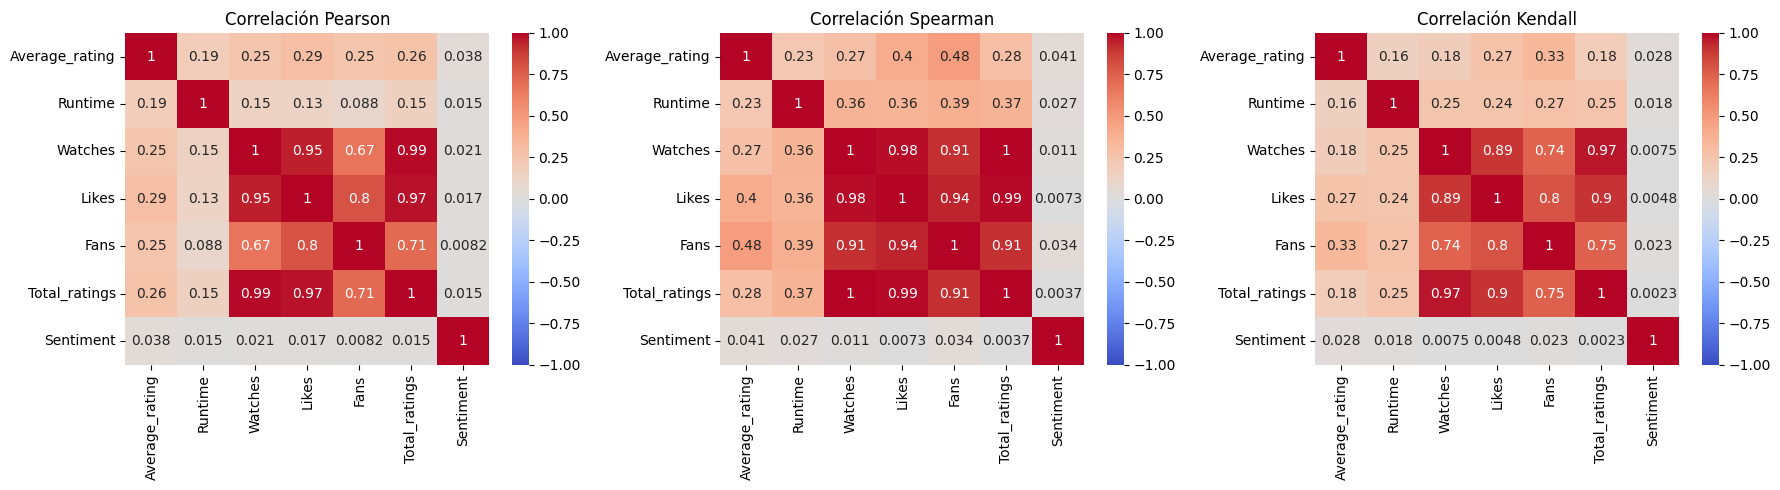

In [ ]:
# Seleccionar columnas numéricas relevantes para correlación
numerical_cols = ['Average_rating', 'Runtime', 'Watches', 'Likes', 'Fans', 'Total_ratings', 'Sentiment']

df_num = df[numerical_cols]

# 1. Matriz de correlación Pearson
corr_pearson = df_num.corr(method='pearson')

# 2. Matriz de correlación Spearman
corr_spearman = df_num.corr(method='spearman')


# 3. Matriz de correlación Kendall
corr_kendall = df_num.corr(method='kendall')

# Visualización con heatmap para cada matriz
plt.figure(figsize=(18, 5))

plt.subplot(1,3,1)
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación Pearson')

plt.subplot(1,3,2)
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación Spearman')

plt.subplot(1,3,3)
sns.heatmap(corr_kendall, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación Kendall')

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("samlearner/letterboxd-movie-ratings-data")

# print("Path to dataset files:", path)

/Users/santiagocasado/Documents/AI/02 Bimestre/05 - Aprendizaje de Maquina I/Trabajo Practica Final/env311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 188M/188M [01:01<00:00, 3.21MB/s] 

Extracting files...


Path to dataset files: /Users/santiagocasado/.cache/kagglehub/datasets/samlearner/letterboxd-movie-ratings-data/versions/6


In [133]:
df_movies = pd.read_csv("Datasets/Letterbox Movie Classification Dataset.csv")
df_movies = df_movies.drop(columns=['Unnamed: 0'])
df_movies.head()

,Film_title,Director,Average_rating,Genres,Runtime,Original_language,Description,Studios,Watches,List_appearances,Likes,Fans,Lowest★,Medium★★★,Highest★★★★★,Total_ratings
0,The Fan,Eckhart Schmidt,3.57,"['Horror', 'Drama']",92.0,German,The hero-worship that Simone has for a pop sin...,['Barbara Moorse Workshop'],12841,11032,3763,79,129,1660,714,9042
1,Mad Max: Fury Road,George Miller,4.18,"['Adventure', 'Science Fiction', 'Action']",121.0,English,An apocalyptic story set in the furthest reach...,"['Warner Bros. Pictures', 'Village Roadshow Pi...",2488721,331681,927538,38000,12530,158356,511140,1682389
2,Suspiria,Dario Argento,3.93,['Horror'],99.0,English,An American newcomer to a prestigious German b...,['Seda Spettacoli'],618171,220094,219548,13000,2814,53427,88628,443757
3,Lost in Translation,Sofia Coppola,3.79,"['Drama', 'Comedy', 'Romance']",102.0,English,"Two lost souls visiting Tokyo -- the young, ne...","['American Zoetrope', 'Elemental Films']",1596190,254180,493248,38000,15167,155110,193717,1076949
4,Akira,Katsuhiro Otomo,4.28,"['Animation', 'Action', 'Science Fiction']",124.0,Japanese,A secret military project endangers Neo-Tokyo ...,"['MBS', 'Sumitomo Corporation', 'TOHO', 'Studi...",873068,175586,341567,21000,1822,40850,196532,600721


## EDA simple

Se hace un EDA rapido solo para justificar el procesamiento del dataset.

### Caracteristicas Generales

### Dimension

In [134]:
df_movies.shape

(10000, 16)

#### Tipo de datos

In [135]:
df_movies.dtypes

Film_title            object
Director              object
Average_rating       float64
Genres                object
Runtime              float64
Original_language     object
Description           object
Studios               object
Watches                int64
List_appearances       int64
Likes                  int64
Fans                   int64
Lowest★                int64
Medium★★★              int64
Highest★★★★★           int64
Total_ratings          int64
dtype: object

### Título (`Film_title`)

In [136]:
df_movies['Film_title'].value_counts()

Film_title
Hercules                        6
Beauty and the Beast            5
A Star Is Born                  4
The Babysitter                  4
The Black Hole                  4
                               ..
Ultimate Avengers: The Movie    1
Step Up                         1
Awaydays                        1
She                             1
Roujin Z                        1
Name: count, Length: 9665, dtype: int64

La cantidad de titulos es muy similar a la cantidad de peliculas del dataset.

### Lenguaje

In [137]:
conteo_lenguajes = df_movies['Original_language'].value_counts()

# Calcular porcentajes
porcentajes_lenguajes = (conteo_lenguajes / conteo_lenguajes.sum()) * 100

print("Distribución de lenguajes originales:")
print(porcentajes_lenguajes.round(2))


Distribución de lenguajes originales:
Original_language
English                             80.74
Italian                              3.96
Japanese                             3.08
French                               2.91
Korean                               1.45
Spanish                              1.15
German                               0.96
No spoken language                   0.94
Chinese                              0.66
Danish                               0.60
Cantonese                            0.58
Russian                              0.43
Swedish                              0.32
Dutch                                0.20
Polish                               0.20
Portuguese                           0.19
Romanian                             0.18
Persian (Farsi)                      0.15
Arabic                               0.14
Norwegian                            0.14
Czech                                0.12
Hindi                                0.09
Greek (modern)      

### Generos

In [138]:
print(df_movies['Genres'].head())
print(type(df_movies['Genres'][0]))

0                           ['Horror', 'Drama']
1    ['Adventure', 'Science Fiction', 'Action']
2                                    ['Horror']
3                ['Drama', 'Comedy', 'Romance']
4    ['Animation', 'Action', 'Science Fiction']
Name: Genres, dtype: object
<class 'str'>


Se observa que cada pelicula puede tener mas de un género y se declaran a partir de un string como si fuera una lista.

## Procesamiento

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer


### Selección de metodos de codificación

#### Titulos

Debido a que `Film_title` corresponde a el nombre de cada película, tomará valores unicos (en la mayoría del dataset) y se lo puede considerar como un ID por lo que no es un feature apto para realizar un modelo de clustering.

#### Director

Features de alta cardinalidad, se utiliza Frequency Encoding. No se realiza One Hot Encoding para evitar alta dimensionalidad y sparsidad excesiva, degradando la calidad de un modelo de clustering.

#### Géneros

In [142]:
import ast

def parse_genres(val):
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except:
        return [val]
    
# Se convierte a tipo lista la variable 'Genres'
df_movies['Genres'] = df_movies['Genres'].apply(parse_genres)

In [143]:
df_movies['Genres'].head()

0                         [Horror, Drama]
1    [Adventure, Science Fiction, Action]
2                                [Horror]
3                [Drama, Comedy, Romance]
4    [Animation, Action, Science Fiction]
Name: Genres, dtype: object

In [144]:
print(type(df_movies['Genres'][0]))

<class 'list'>


Se utilizan los 19 primeros generos mas frecuentes:

In [207]:
from collections import Counter

all_genres = [g for sublist in df_movies['Genres'] for g in sublist]
counter = Counter(all_genres)

top_19 = [g for g, _ in counter.most_common(19)]
print("Top 19 géneros:", top_19)

Top 19 géneros: ['Drama', 'Comedy', 'Thriller', 'Action', 'Horror', 'Crime', 'Adventure', 'Romance', 'Science Fiction', 'Fantasy', 'Mystery', 'Family', 'Animation', 'History', 'Documentary', 'War', 'Music', 'Western', 'TV Movie']


El resto se pasa a una nueva categoria 'Others':

In [233]:
def reemplazar_Others(genres):
    return [g if g in top_19 else "Others" for g in genres]

df_movies['Genres'] = df_movies['Genres'].apply(reemplazar_Others)

Debido a que `Genre` tiene cardinalidad baja, se utilzará `Multi Label Binarizer` para codificar los datos. De esta manera, se crea una columna booleana para cada género donde tomará el valor 1 si este pertenece a la película. Cabe mencionar que las columnas no son mutuamente excluyentes, por lo que se respeta que pueda cada una tener mas de un genero.

#### Lenguajes

Se eligen los primeros 9 lenguajes mas frecuentes. El resto se pasa a la categoria 'others'.

In [147]:
# Se muestra el Top 9 de lenguajes

top_9_lenguajes = df_movies['Original_language'].value_counts().head(9).index.tolist()
print(top_9_lenguajes)

['English', 'Italian', 'Japanese', 'French', 'Korean', 'Spanish', 'German', 'No spoken language', 'Chinese']


In [148]:
# Nueva columna para agrupar los lenguajes
df_movies['Language_group'] = df_movies['Original_language'].apply(
    lambda x: x if x in top_9_lenguajes else 'Others'
)

df_movies['Language_group'] = df_movies['Language_group'].astype('category')

# Se verifica que los que estan con la categoría "Others" no pertenecen a los 9 lenguajes más comunes
df_movies[df_movies['Language_group'] == 'Others'][['Original_language', 'Language_group']].head()

,Original_language,Language_group
66,Cantonese,Others
73,Indonesian,Others
114,Russian,Others
115,Russian,Others
166,Swedish,Others


Como `Language_group` tiene cardinalidad 10, se utilizará One Hot Encoding para codificar.

### Conversión de tipos

In [ ]:
# Categoricas
categoricas = ['Film_title', 'Director', 'Genres', 'Original_language', 'Description', 'Studios', 'Language_group']
df_movies[categoricas] = df_movies[categoricas].astype('category')
df_movies.dtypes

### Transformación de datos

In [260]:
# Se agrupan las columnas por tipo de datos o cardinalidad
numericas = []
binarias = []
temporales = []
ordinales = []
baja_cardinalidad = ['Language_group']
alta_cardinalidad = ['Director', 'Studios']

#### Transformar `Genres`

In [ ]:
mlb = MultiLabelBinarizer()

mlb_encode = mlb.fit_transform(df_movies['Genres'])

df_genres = pd.DataFrame(
    mlb_encode,
    columns=mlb.classes_,
    index=df_movies.index
)

df_genres.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Others,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [318]:
binarias = df_genres.columns.tolist()

binarias

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Others',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western']

In [307]:
# Se concatena al dataframe original

df_movies_preprocesado = pd.concat([df_movies.drop(columns=['Genres_top', 'Genres']), df_genres], axis=1)

df_movies_preprocesado.head()

,Film_title,Director,Average_rating,Runtime,Original_language,Description,Studios,Watches,List_appearances,Likes,...,Horror,Music,Mystery,Others,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,The Fan,Eckhart Schmidt,3.57,92.0,German,The hero-worship that Simone has for a pop sin...,['Barbara Moorse Workshop'],12841,11032,3763,...,1,0,0,0,0,0,0,0,0,0
1,Mad Max: Fury Road,George Miller,4.18,121.0,English,An apocalyptic story set in the furthest reach...,"['Warner Bros. Pictures', 'Village Roadshow Pi...",2488721,331681,927538,...,0,0,0,0,0,1,0,0,0,0
2,Suspiria,Dario Argento,3.93,99.0,English,An American newcomer to a prestigious German b...,['Seda Spettacoli'],618171,220094,219548,...,1,0,0,0,0,0,0,0,0,0
3,Lost in Translation,Sofia Coppola,3.79,102.0,English,"Two lost souls visiting Tokyo -- the young, ne...","['American Zoetrope', 'Elemental Films']",1596190,254180,493248,...,0,0,0,0,1,0,0,0,0,0
4,Akira,Katsuhiro Otomo,4.28,124.0,Japanese,A secret military project endangers Neo-Tokyo ...,"['MBS', 'Sumitomo Corporation', 'TOHO', 'Studi...",873068,175586,341567,...,0,0,0,0,0,1,0,0,0,0


#### Transformar Baja Cardinalidad

In [299]:
transformar_baja_cardinalidad = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

#### Transformar Alta Cardinalidad

In [311]:
# Frecuency encoding
def freq_encode_list_col_ft(X):
    # Convertir a Series para facilidad
    if isinstance(X, np.ndarray):
        s = pd.Series(X[:,0])
    else:
        s = pd.Series(X.iloc[:,0])
    
    # Parsear strings tipo "['a','b']" a listas
    s = s.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else ([x] if pd.notna(x) else []))
    
    # Contar frecuencia global
    all_items = [i for sublist in s for i in sublist]
    counts = Counter(all_items)
    
    # Codificar cada fila como promedio de frecuencias
    freq = s.apply(lambda lst: sum(counts.get(x,0) for x in lst)/len(lst) if lst else 0)
    
    return freq.to_numpy().reshape(-1,1)

from sklearn.base import BaseEstimator, TransformerMixin


# Clase para matener el nombre de la columna
class FrequencyEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.func(X)
    
    def get_feature_names_out(self, input_features=None):
        # Retorna una lista con el nombre de la columna
        if input_features is None:
            return ["Studios_freq"]
        else:
            return [f"{col}_freq" for col in input_features]


class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func

    def fit(self, X, y=None):
        self.encoders_ = {}
        for col in X.columns:
            freqs = X[col].value_counts(normalize=True)
            self.encoders_[col] = freqs
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = X[col].map(self.encoders_[col]).fillna(0)
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        return input_features


# transformar_nominales = Pipeline([
#     ("freq", FrequencyEncoderTransformer(freq_encode_list_col_ft)),
#     ("scaler", MinMaxScaler())
# ])

transformar_nominales = Pipeline([
    ("freq", FrequencyEncoder(freq_encode_list_col_ft)),
    ("scaler", MinMaxScaler())
])

In [323]:
import re
from sklearn.compose import ColumnTransformer

preprocesamiento = ColumnTransformer(
    transformers=[
        #('numericas', transformas_numericas, numericas),
        #('binarios', 'passthrough', binarios),
        #('ordinales', transformar_ordinales, ordinales),
        ('multi_label', 'passthrough', binarias),
        ('ohe', transformar_baja_cardinalidad, baja_cardinalidad),
        ('freq', transformar_nominales, alta_cardinalidad),
    ],
    remainder='drop'
)

In [324]:
pipeline = Pipeline(
    steps=[('preprocesamiento', preprocesamiento)]
    )

# Se procesan los datos
df_movies_procesado = pipeline.fit_transform(df_movies_preprocesado) 

pipeline

,steps,"[('preprocesamiento', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('multi_label', ...), ('ohe', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [325]:
from numpy import var


variables = pipeline.named_steps['preprocesamiento'].get_feature_names_out()

# pasos_preprocesador_ajustado = pipeline.named_steps['preprocesamiento']
# pasos_pipeline_binarias = pasos_preprocesador_ajustado.named_transformers_['ohe']
# pasos_onehot_encoder = pasos_pipeline_binarias.named_steps['ohe'] 
# binarias_salida = pasos_onehot_encoder.get_feature_names_out(baja_cardinalidad)
#print(binarias_salida)
#print(variables)

print(f"Shape de df procesado: {df_movies_procesado.shape}")
print(f"len variables: {len(variables)}")
print(f"shape df original: {df_movies.shape}")


df_movies_reestructurado = pd.DataFrame(
    df_movies_procesado,
    columns=variables,
    index=df_movies.index
)

df_movies_reestructurado.head()

Shape de df procesado: (10000, 31)
len variables: 31
shape df original: (10000, 18)


,multi_label__Action,multi_label__Adventure,multi_label__Animation,multi_label__Comedy,multi_label__Crime,multi_label__Documentary,multi_label__Drama,multi_label__Family,multi_label__Fantasy,multi_label__History,...,ohe__Language_group_French,ohe__Language_group_German,ohe__Language_group_Italian,ohe__Language_group_Japanese,ohe__Language_group_Korean,ohe__Language_group_No spoken language,ohe__Language_group_Others,ohe__Language_group_Spanish,freq__Director,freq__Studios
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.000000
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081633,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183673,0.003268
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.020408,0.000000
